<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd


gdd.download_file_from_google_drive(file_id='1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9',
                                    dest_path='./faces_dataset.rar',
                                    unzip=False)

!mkdir images
!unzip -q faces_dataset.rar -d ./images
!rm -r ./images/faces_dataset_small/04000
!rm -r ./images/__MACOSX
!rm faces_dataset.rar
# img_path = "./faces_dataset_small/04990.png"

In [ ]:
def get_dataloader(image_size, batch_size, images_stats):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :param images_stats: mean and std of images in the dataset
    :returns: DataLoader object 
    """
    train_ds = ImageFolder("./images/", transform=tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      tt.Normalize(*images_stats)
    ]))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, 
                          pin_memory=True)
    
    return train_dl

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 128
IMAGES_STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = get_dataloader(IMAGE_SIZE, BATCH_SIZE, IMAGES_STATS)

In [ ]:
def denorm_images(img_tensors):
    return img_tensors * IMAGES_STATS[1][0] + IMAGES_STATS[0][0]

def show_images(images, nmax=25):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm_images(images.detach()[:nmax]), nrow=5).permute(1, 2, 0))

def show_batch(dl, nmax=25):
    for images, _ in dl:
        show_images(images, nmax)
        break

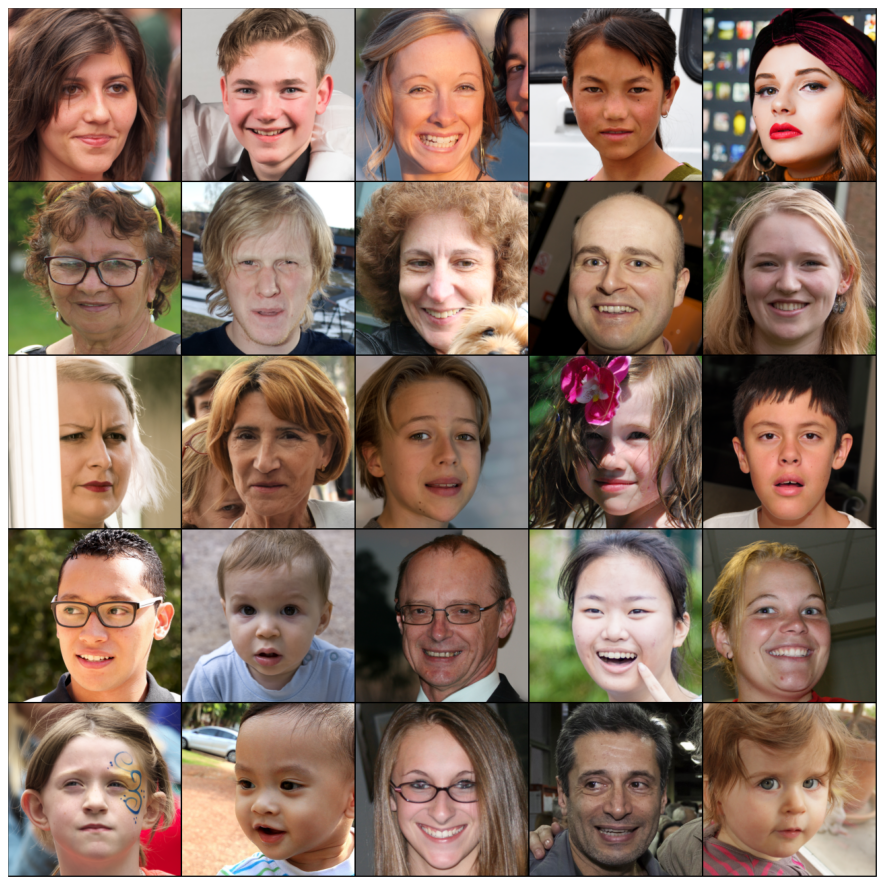

In [ ]:
show_batch(train_loader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_feat, hid_feat, out_feat):
        super().__init__()

        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_feat), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_feat, hid_feat, kernel_size=1, stride=1, bias=False),

            nn.BatchNorm2d(hid_feat),
            nn.ReLU(inplace=True),
            nn.Conv2d(hid_feat, out_feat, kernel_size=3, stride=1, padding=1, 
                      bias=False),
        )

    def forward(self, x):
        output = self.layer(x)
        return output

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_feat, hid_feat, out_feat):
        super().__init__()

        self.denselayer1 = DenseLayer(in_feat, hid_feat, out_feat)
        self.denselayer2 = DenseLayer(in_feat+out_feat, hid_feat, out_feat)
        self.denselayer3 = DenseLayer(in_feat+2*out_feat, hid_feat, out_feat)
        self.denselayer4 = DenseLayer(in_feat+3*out_feat, hid_feat, out_feat)

    def forward(self, x):
        inp = x
        outp = self.denselayer1(x)
        layers = (self.denselayer2, self.denselayer3, self.denselayer4)
        
        for i in range(3):
            inp = torch.concat([inp, outp], dim=1)
            outp = layers[i](inp)

        return torch.concat([inp, outp], dim=1)


class TransitionLayer(nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()

        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_feat), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_feat, out_feat, kernel_size=1, stride=1),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        output = self.layer(x)
        return output

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Flatten(), 

    nn.Dropout(0.25),
    nn.Linear(256*8*8, 1), 
    nn.Sigmoid()

).to(DEVICE)

In [ ]:
latent_size = 256

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # out: 16 x 128 x 128

    nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256

).to(DEVICE)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0005

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": optim.Adam(model["discriminator"].parameters()),
    "generator": optim.Adam(model["generator"].parameters())
}

In [ ]:
def fit(model, criterion, optimizer, epochs, tr_loader):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g, losses_d = [], []
    real_scores, fake_scores = [], []
    
    for epoch in range(epochs):
        epoch_d_loss, epoch_g_loss = [], []
        epoch_real_score, epoch_fake_score = [], []

        for real_images, _ in tqdm(tr_loader):
            real_images = real_images.to(DEVICE)
            rand_noise = torch.rand(BATCH_SIZE, 1, device=DEVICE) / 20
            
            ###################### Train discriminator #########################
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            real_targets -= rand_noise[:real_images.size(0)]
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE)
            fake_targets += rand_noise
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            epoch_real_score.append(cur_real_score)
            epoch_fake_score.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            epoch_d_loss.append(loss_d.item())

            ######################### Train generator ##########################
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=DEVICE) - rand_noise
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            epoch_g_loss.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(epoch_g_loss))
        losses_d.append(np.mean(epoch_d_loss))
        real_scores.append(np.mean(epoch_real_score))
        fake_scores.append(np.mean(epoch_fake_score))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
from torchsummary import summary


print(summary(discriminator, (3, 256, 256), 128))
print(summary(generator, (latent_size, 1, 1), 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 128, 128]           3,072
       BatchNorm2d-2        [128, 64, 128, 128]             128
         LeakyReLU-3        [128, 64, 128, 128]               0
            Conv2d-4         [128, 128, 64, 64]         131,072
       BatchNorm2d-5         [128, 128, 64, 64]             256
         LeakyReLU-6         [128, 128, 64, 64]               0
            Conv2d-7         [128, 256, 32, 32]         524,288
       BatchNorm2d-8         [128, 256, 32, 32]             512
         LeakyReLU-9         [128, 256, 32, 32]               0
           Conv2d-10         [128, 512, 16, 16]       2,097,152
      BatchNorm2d-11         [128, 512, 16, 16]           1,024
        LeakyReLU-12         [128, 512, 16, 16]               0
           Conv2d-13           [128, 256, 8, 8]       2,097,152
      BatchNorm2d-14           [128, 25

In [ ]:
history = fit(model, criterion, optimizer, 25, train_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 8.5006, loss_d: 2.1130, real_score: 0.9320, fake_score: 0.1315


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 6.8419, loss_d: 0.3586, real_score: 0.9708, fake_score: 0.0371


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 10.7361, loss_d: 0.5942, real_score: 0.9402, fake_score: 0.0439


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 11.4482, loss_d: 1.1089, real_score: 0.9452, fake_score: 0.0729


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 7.7490, loss_d: 0.4552, real_score: 0.9657, fake_score: 0.0535


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 9.5432, loss_d: 0.4213, real_score: 0.9645, fake_score: 0.0294


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.7591, loss_d: 0.3692, real_score: 0.9762, fake_score: 0.0266


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.7430, loss_d: 0.2749, real_score: 0.9698, fake_score: 0.0294


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.6661, loss_d: 0.3016, real_score: 0.9645, fake_score: 0.0356


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.5867, loss_d: 0.2844, real_score: 0.9651, fake_score: 0.0343


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.8117, loss_d: 0.5042, real_score: 0.9335, fake_score: 0.0470


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 4.5137, loss_d: 0.3681, real_score: 0.9647, fake_score: 0.0383


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.3500, loss_d: 0.2893, real_score: 0.9677, fake_score: 0.0320


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.2957, loss_d: 0.2678, real_score: 0.9645, fake_score: 0.0334


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.5133, loss_d: 0.2635, real_score: 0.9649, fake_score: 0.0360


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.0392, loss_d: 0.2745, real_score: 0.9686, fake_score: 0.0304


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 5.5576, loss_d: 0.2643, real_score: 0.9704, fake_score: 0.0319


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 8.5531, loss_d: 0.4093, real_score: 0.9630, fake_score: 0.0381


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.4146, loss_d: 0.2712, real_score: 0.9701, fake_score: 0.0342


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.6039, loss_d: 0.2677, real_score: 0.9655, fake_score: 0.0363


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.7083, loss_d: 0.2635, real_score: 0.9608, fake_score: 0.0385


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.5835, loss_d: 0.2641, real_score: 0.9702, fake_score: 0.0322


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.4596, loss_d: 0.2588, real_score: 0.9708, fake_score: 0.0298


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.4458, loss_d: 0.2529, real_score: 0.9730, fake_score: 0.0261


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.7371, loss_d: 0.2690, real_score: 0.9631, fake_score: 0.0357


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

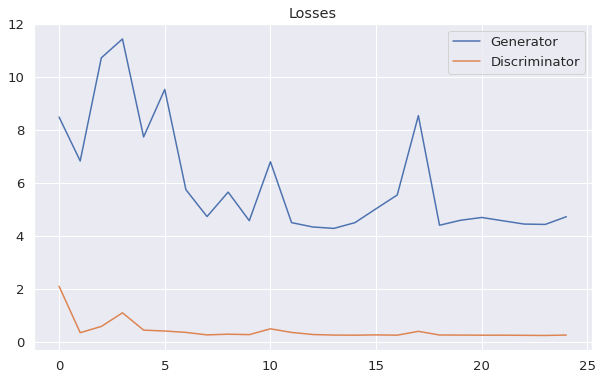

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(losses_g, label="Generator")
plt.plot(losses_d, label="Discriminator")
plt.title("Losses")
plt.grid(True)
plt.legend()
plt.show()

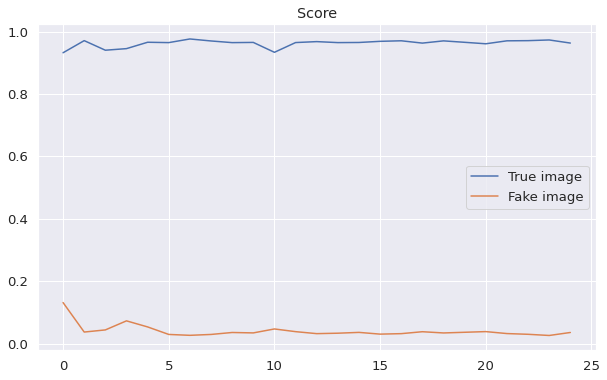

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(real_scores, label="True image")
plt.plot(fake_scores, label="Fake image")
plt.title("Score")
plt.grid(True)
plt.legend()
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
def generate_images(n_images):
    fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
    fake_images = model["generator"](fixed_latent)
    return fake_images


fake_images = generate_images(9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


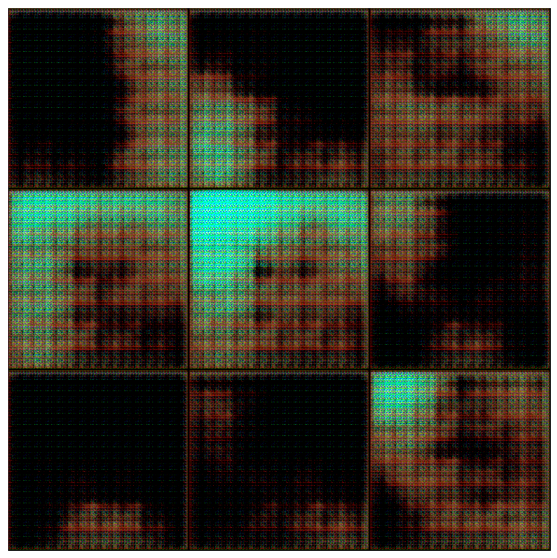

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu(), nrow=3).permute(1, 2, 0))

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
fake_images = generate_images(BATCH_SIZE)
real_images, _ = next(iter(train_loader))

fake_images = fake_images.cpu()
real_images = real_images.cpu()

images_to_classify = torch.concat([fake_images, real_images], dim=0).detach().numpy()
images_to_classify = images_to_classify.reshape(2*BATCH_SIZE, -1)
labels = np.append(np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE))

In [ ]:
loo = LeaveOneOut()
pred_labels = []

for train_idx, test_idx in loo.split(images_to_classify):
    X_train, X_test = images_to_classify[train_idx], images_to_classify[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    knn_classifier = KNeighborsClassifier(n_neighbors=1, p=1, n_jobs=-1)
    knn_classifier.fit(X_train, y_train)
    pred_labels.append(knn_classifier.predict(X_test))

In [ ]:
from sklearn.metrics import accuracy_score


pred_labels = np.array(pred_labels)
acc = accuracy_score(pred_labels, labels)
print(acc)

0.984375


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, learning_rate="auto", init="pca")
compressed_images = tsne.fit_transform(images_to_classify)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [ ]:
compressed_images[161]

array([-37.035362, -90.635826], dtype=float32)

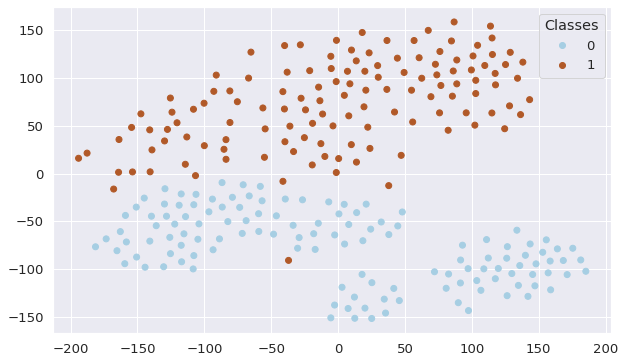

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(compressed_images[:, 0], compressed_images[:, 1], c=labels, 
                      cmap="Paired")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

Прокомментируйте получившийся результат: